# Step 1. Import data from the webscraping

In [32]:
import pandas as pd
import glob
import os

# Get the parent directory path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Find all files in the parent directory matching the webscrape pattern
csv_pattern = os.path.join(parent_dir, "webscrape_*.csv")
csv_files = glob.glob(csv_pattern)

# Store column headers for each file
all_headers = {}
consistent = True
first_file = None

print(f"Found {len(csv_files)} webscrape CSV files")

# Loop through each file and get headers
for file in csv_files:
    filename = os.path.basename(file)
    
    # Just read the headers without loading entire file
    headers = pd.read_csv(file, nrows=0).columns.tolist()
    all_headers[filename] = headers
    
    # Store first file's headers as reference
    if first_file is None:
        first_file = filename
        reference_headers = headers
        print(f"Reference headers from {first_file}: {reference_headers}")
    # Compare current file with reference
    elif headers != reference_headers:
        consistent = False
        print(f"\nMISMATCH in {filename}:")
        
        # Find and show differences
        missing = set(reference_headers) - set(headers)
        extra = set(headers) - set(reference_headers)
        
        if missing:
            print(f"  Missing columns: {missing}")
        if extra:
            print(f"  Extra columns: {extra}")

# Print final result
if consistent:
    print("\nAll files have identical column headers")
else:
    print("\nWarning: Column headers differ between files")

Found 73 webscrape CSV files
Reference headers from webscrape_2023-08-15_09-20-02.csv: ['title', 'company', 'location', 'salary', 'description']

All files have identical column headers


# Step 2. Add date and date-times so we can identify where each job came from

In [33]:
# Create DataFrames with dates extracted from filenames
import pandas as pd
import re
from datetime import datetime

# Dictionary to store all DataFrames
dataframes = {}

# Regular expression to extract date and time from filename
date_pattern = r'webscrape_(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})\.csv'

# Process each CSV file
for file in csv_files:
    filename = os.path.basename(file)
    
    # Extract date using regex
    match = re.search(date_pattern, filename)
    if match:
        date_str = match.group(1)  # YYYY-MM-DD
        time_str = match.group(2).replace('-', ':')  # Convert to HH:MM:SS
        datetime_str = f"{date_str} {time_str}"
        
        # Parse to datetime object
        file_datetime = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
        
        # Read the CSV
        df = pd.read_csv(file)
        
        # Add date columns
        df['scrape_date'] = file_datetime.date()
        df['scrape_datetime'] = file_datetime
        
        # Store in dictionary
        dataframes[filename] = df
        
        print(f"Loaded {filename} with {len(df)} rows, scraped on {file_datetime}")
    else:
        print(f"Warning: Couldn't extract date from {filename}")

print(f"\nProcessed {len(dataframes)} files")

# Example to verify date columns were added correctly
if dataframes:
    first_key = list(dataframes.keys())[0]
    print(f"\nExample from {first_key}:")
    print(dataframes[first_key][['scrape_date', 'scrape_datetime']].head(2))

Loaded webscrape_2023-08-15_09-20-02.csv with 3923 rows, scraped on 2023-08-15 09:20:02
Loaded webscrape_2023-08-23_09-55-48.csv with 4151 rows, scraped on 2023-08-23 09:55:48
Loaded webscrape_2023-08-30_10-13-36.csv with 3897 rows, scraped on 2023-08-30 10:13:36
Loaded webscrape_2023-09-07_09-32-27.csv with 4266 rows, scraped on 2023-09-07 09:32:27
Loaded webscrape_2023-09-27_11-14-05.csv with 3458 rows, scraped on 2023-09-27 11:14:05
Loaded webscrape_2023-10-04_09-34-49.csv with 3712 rows, scraped on 2023-10-04 09:34:49
Loaded webscrape_2023-10-11_07-59-43.csv with 3362 rows, scraped on 2023-10-11 07:59:43
Loaded webscrape_2023-10-18_09-22-00.csv with 3899 rows, scraped on 2023-10-18 09:22:00
Loaded webscrape_2023-11-01_08-31-18.csv with 4629 rows, scraped on 2023-11-01 08:31:18
Loaded webscrape_2023-11-08_10-36-53.csv with 1859 rows, scraped on 2023-11-08 10:36:53
Loaded webscrape_2023-11-22_10-11-56.csv with 2762 rows, scraped on 2023-11-22 10:11:56
Loaded webscrape_2023-11-29_10-0

# Step 3. Merge the webscrape CSVs

In [34]:
# Merge all DataFrames into one combined dataset
import pandas as pd

# Check if we have DataFrames to merge
if not dataframes:
    print("No DataFrames to merge!")
else:
    # Combine all DataFrames from the dictionary
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    
    # Basic info about the combined dataset
    print(f"Combined dataset created successfully!")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Show unique scrape dates to verify we have data from different days
    unique_dates = combined_df['scrape_date'].unique()
    print(f"\nData includes {len(unique_dates)} unique dates:")
    for date in sorted(unique_dates):
        count = len(combined_df[combined_df['scrape_date'] == date])
        print(f"  {date}: {count:,} rows")
    
    # Preview of the combined data
    print("\nPreview of combined dataset:")
    # Show date columns first, then a few others
    preview_cols = ['scrape_date', 'scrape_datetime'] 
    # Add a few more columns for preview (adjust as needed)
    other_cols = [col for col in combined_df.columns 
                 if col not in ['scrape_date', 'scrape_datetime']][:3]
    preview_cols.extend(other_cols)
    
    print(combined_df[preview_cols].head())

Combined dataset created successfully!
Total rows: 253,897
Total columns: 7

Data includes 72 unique dates:
  2023-08-15: 3,923 rows
  2023-08-23: 4,151 rows
  2023-08-30: 3,897 rows
  2023-09-07: 4,266 rows
  2023-09-27: 3,458 rows
  2023-10-04: 3,712 rows
  2023-10-11: 3,362 rows
  2023-10-18: 3,899 rows
  2023-11-01: 4,629 rows
  2023-11-08: 1,859 rows
  2023-11-22: 2,762 rows
  2023-11-29: 2,931 rows
  2023-12-06: 3,958 rows
  2023-12-13: 4,141 rows
  2023-12-20: 3,775 rows
  2024-01-03: 3,193 rows
  2024-01-10: 4,081 rows
  2024-01-17: 3,630 rows
  2024-01-31: 3,239 rows
  2024-02-07: 3,268 rows
  2024-02-14: 3,427 rows
  2024-02-21: 3,644 rows
  2024-03-13: 3,050 rows
  2024-03-20: 3,491 rows
  2024-03-27: 2,945 rows
  2024-04-10: 3,504 rows
  2024-04-17: 4,330 rows
  2024-04-24: 3,500 rows
  2024-05-01: 2,978 rows
  2024-05-08: 3,199 rows
  2024-05-15: 2,871 rows
  2024-05-22: 2,951 rows
  2024-05-29: 2,248 rows
  2024-06-05: 2,983 rows
  2024-06-12: 2,814 rows
  2024-06-19: 2,5

# Step 4. Tidying data.

## 4.1. Removing rows that aren't jobs.

### 4.1.1. Where 'illustration of bank notes' in job title

In [35]:
# Remove rows where title contains "Illustration of banknotes" with flexible matching

# First check if title column exists
if "title" not in combined_df.columns:
    print("Warning: 'title' column not found in the dataset.")
else:
    # Display some titles to understand what we're working with
    print("Sample of titles in the dataset:")
    sample_titles = combined_df["title"].dropna().sample(min(5, len(combined_df))).tolist()
    for title in sample_titles:
        print(f"  - {title}")
    
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches more flexibly
    potential_matches = combined_df[combined_df["title"].str.contains("Illustration of banknote", case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with 'Illustration of banknote'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching titles:")
        for title in potential_matches["title"].unique()[:5]:
            print(f"  - {title}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["title"].str.contains("Illustration of banknote", case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()

Sample of titles in the dataset:
  -                     Highly Specialist Dietitian (Band 7)
  -                     Healthcare Advisory Solicitor
  -                     Outpatient Eating Disorder Nursing Assistant
  -                 Illustration of banknotes
  -                     Mobile BMS

Found 4659 potential matches with 'Illustration of banknote'

Sample of matching titles:
  -                 Illustration of banknotes
  - 
                Illustration of banknotes

Original dataset: 253,897 rows
Removed: 4,659 rows
Filtered dataset: 249,238 rows


### 4.1.2. Where company includes 'boost your CV'

In [36]:
# Remove rows where company contains "Boost your CV"

# First check if company column exists
if "company" not in combined_df.columns:
    print("Warning: 'company' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches more flexibly
    potential_matches = combined_df[combined_df["company"].str.contains("Boost your CV", case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with 'Boost your CV'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching company entries:")
        for company in potential_matches["company"].unique()[:3]:
            print(f"  - {company}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["company"].str.contains("Boost your CV", case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()


Found 3500 potential matches with 'Boost your CV'

Sample of matching company entries:
  -         Boost your CV
        It takes 2 minutes and it's free.Try ValueMyCV now ❯

Original dataset: 249,238 rows
Removed: 3,500 rows
Filtered dataset: 245,738 rows


### 4.1.3. Where company contains 'recent the newest jobs for this search'

In [37]:
# Remove rows where company contains "Receive the newest jobs"

# First check if company column exists
if "company" not in combined_df.columns:
    print("Warning: 'company' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Look at potential matches with flexible matching
    search_phrase = "Receive the newest jobs"
    potential_matches = combined_df[combined_df["company"].str.contains(search_phrase, case=False, na=False)]
    print(f"\nFound {len(potential_matches)} potential matches with '{search_phrase}'")
    
    if len(potential_matches) > 0:
        print("\nSample of matching company entries:")
        for company in potential_matches["company"].unique()[:3]:
            print(f"  - {company}")
    
    # Remove rows with flexible matching
    filtered_df = combined_df[~combined_df["company"].str.contains(search_phrase, case=False, na=False)]
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {original_count - len(filtered_df):,} rows")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()


Found 5608 potential matches with 'Receive the newest jobs'

Sample of matching company entries:
  -             Receive the newest jobs for this search by email:

Original dataset: 245,738 rows
Removed: 5,608 rows
Filtered dataset: 240,130 rows


### Step 4.1.4. Remove missing salaries

##### *Preliminary check*

We first check to see if any of these rows actually contain the salary in the job description. Our analysis below shows that:
1. All of the rows that have a £ sign in the job title already have a salary in the salary, so
2. Missing salaries are not found in the job title, and
3. Where a salary is cited in the job title *and* the salary field, these are usually consistent. They differ usually by unit (i.e. £11p/h becomes £11 in the salary field)

In [38]:
# Updated salary extraction with improved regex patterns

# First check if combined_df exists
if "title" not in combined_df.columns or "salary" not in combined_df.columns:
    print("Warning: Missing required columns")
else:
    # Create DF with rows that have '£' in title AND non-null salary field
    pound_in_title = combined_df["title"].str.contains("£", na=False)
    has_salary_value = ~combined_df["salary"].isna()
    comparison_df = combined_df[pound_in_title & has_salary_value].copy()
    
    print(f"Found {len(comparison_df):,} rows with '£' in title AND salary field populated")
    
    # Improved function to extract salary from title
    def extract_salary_from_title(title):
        # Updated patterns with optional space after £
        patterns = [
            r'£\s*(\d{1,3}[,.]?\d{0,3}[kK]?)', # Basic amounts like £50k, £ 50,000
            r'£\s*(\d{1,3}[,.]?\d{0,3})-£?\s*(\d{1,3}[,.]?\d{0,3}[kK]?)', # Ranges like £30-£40k or £ 30-£ 40k
            r'£\s*(\d{1,3}[,.]?\d{0,3}[kK]?)[/\s]*(day|hour|month|year|pa|p\.a\.)', # With time period
            r'£\s*(\d{1,3}[,.]?\d{0,3})[kK]\s*-\s*£?\s*(\d{1,3}[,.]?\d{0,3})[kK]', # Format like £24K-£32K
        ]
        
        for pattern in patterns:
            match = re.search(pattern, title)
            if match:
                return match.group(0)
        return None
    
    # Add extracted salary column
    comparison_df['title_salary'] = comparison_df['title'].apply(extract_salary_from_title)
    
    # Count how many titles we could extract salaries from
    extracted_count = comparison_df['title_salary'].notna().sum()
    print(f"Successfully extracted salary from {extracted_count} titles ({extracted_count/len(comparison_df)*100:.1f}%)")
    
    # Check the previously failed cases
    try:
        failed_before = failed_extraction_df.copy()
        failed_before['updated_title_salary'] = failed_before['title'].apply(extract_salary_from_title)
        
        newly_extracted = failed_before['updated_title_salary'].notna().sum()
        print(f"\nOf the {len(failed_before)} previously failed extractions:")
        print(f"  - Now successfully extracted: {newly_extracted} ({newly_extracted/len(failed_before)*100:.1f}%)")
        
        if newly_extracted > 0:
            print("\nNewly extracted examples:")
            for _, row in failed_before[failed_before['updated_title_salary'].notna()].iterrows():
                print(f"Title: {row['title']}")
                print(f"  - Extracted salary: {row['updated_title_salary']}")
                print(f"  - Salary field: {row['salary']}")
                print()
    except NameError:
        print("\nPreviously failed cases dataset not available.")
    
    # Get current failed extractions
    failed_now = comparison_df[comparison_df['title_salary'].isna() & comparison_df['title'].str.contains('£', na=False)]
    print(f"\nStill failed to extract from {len(failed_now)} titles")
    
    if len(failed_now) > 0 and len(failed_now) <= 20:
        print("\nRemaining failure cases:")
        for _, row in failed_now.iterrows():
            print(f"Title: {row['title']}")
            print(f"Salary field: {row['salary']}")
            print()

Found 4,575 rows with '£' in title AND salary field populated
Successfully extracted salary from 4564 titles (99.8%)

Previously failed cases dataset not available.

Still failed to extract from 11 titles

Remaining failure cases:
Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £65,000

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £60,000

Title:                     Vet Surgeon Vacancy - First Opinion Small Animal - Manchester Central Area (to £
Salary field: £65

Title:                     Post Market Surveillance Manager - Oxford - £Competitive
Salary field: £60,000

Title:                     Post Market Surveillance Manager - Oxfor

In [39]:
# Compare extracted salary from title with salary field

# First ensure we have the updated extracted salary data
if 'comparison_df' not in locals() or 'title_salary' not in comparison_df.columns:
    print("Error: Please run the updated salary extraction code first")
else:
    # Focus only on rows where we successfully extracted a salary
    valid_comparisons = comparison_df[comparison_df['title_salary'].notna()].copy()
    
    print(f"Analyzing {len(valid_comparisons)} rows with successfully extracted title salaries")
    
    # Function to normalize salary for comparison
    def normalize_salary(salary_text):
        # Convert to string if not already
        salary_str = str(salary_text).lower()
        # Remove spaces and common separators
        salary_str = salary_str.replace(' ', '').replace(',', '')
        return salary_str
    
    # Add normalized versions of both salary fields
    valid_comparisons['norm_title_salary'] = valid_comparisons['title_salary'].apply(normalize_salary)
    valid_comparisons['norm_field_salary'] = valid_comparisons['salary'].apply(normalize_salary)
    
    # Check for matches (using contains rather than exact match)
    valid_comparisons['exact_match'] = valid_comparisons['norm_title_salary'] == valid_comparisons['norm_field_salary']
    valid_comparisons['partial_match'] = valid_comparisons.apply(
        lambda row: (row['norm_title_salary'] in row['norm_field_salary'] or 
                     row['norm_field_salary'] in row['norm_title_salary']), 
        axis=1
    )
    
    # Count match types
    exact_matches = valid_comparisons['exact_match'].sum()
    partial_matches = valid_comparisons['partial_match'].sum() - exact_matches  # Remove overlap with exact
    no_matches = len(valid_comparisons) - exact_matches - partial_matches
    
    # Calculate percentages
    total = len(valid_comparisons)
    exact_pct = (exact_matches / total) * 100
    partial_pct = (partial_matches / total) * 100
    no_match_pct = (no_matches / total) * 100
    
    # Print match statistics
    print("\nSalary match analysis:")
    print(f"  - Exact matches: {exact_matches:,} ({exact_pct:.1f}%)")
    print(f"  - Partial matches: {partial_matches:,} ({partial_pct:.1f}%)")
    print(f"  - No match: {no_matches:,} ({no_match_pct:.1f}%)")
    
    # Show examples of each type
    print("\nEXAMPLES OF EXACT MATCHES:")
    for _, row in valid_comparisons[valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()
    
    print("\nEXAMPLES OF PARTIAL MATCHES:")
    for _, row in valid_comparisons[valid_comparisons['partial_match'] & ~valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()
    
    print("\nEXAMPLES OF NO MATCHES:")
    for _, row in valid_comparisons[~valid_comparisons['partial_match'] & ~valid_comparisons['exact_match']].head(3).iterrows():
        print(f"Title: {row['title']}")
        print(f"  - Title salary: {row['title_salary']}")
        print(f"  - Field salary: {row['salary']}")
        print()

Analyzing 4564 rows with successfully extracted title salaries

Salary match analysis:
  - Exact matches: 1,424 (31.2%)
  - Partial matches: 3,140 (68.8%)
  - No match: 0 (0.0%)

EXAMPLES OF EXACT MATCHES:
Title:                     Associate Dentist - £14-15 per UDA
  - Title salary: £14
  - Field salary: £14

Title:                     Associate Dentist - Up to £14 per UDA
  - Title salary: £14
  - Field salary: £14

Title:                     Dental Nurse - £12 per hour
  - Title salary: £12
  - Field salary: £12


EXAMPLES OF PARTIAL MATCHES:
Title:                     Newly Qualified Registered Nurse (RGN/RMN/RNLD) – Preston – Nursing Home Setting – £19.00 per hour – Full Training and Support Provided.
  - Title salary: £19.00
  - Field salary: £19

Title:                     Vet Surgeon Vacancy - small animal & exotics - Wirral (to £70K)
  - Title salary: £70K
  - Field salary: £70

Title:                     Newly Qualified Registered Nurse (RGN/RMN/RNLD) – Burnley – Nursing Hom

##### *Removal*

In [40]:
# Remove rows where 'salary' is missing (now that we've verified salary data quality)

# First check if salary column exists
if "salary" not in combined_df.columns:
    print("Warning: 'salary' column not found in the dataset.")
else:
    # Count original rows
    original_count = len(combined_df)
    
    # Check how many rows have missing salary values
    missing_salary_count = combined_df["salary"].isna().sum()
    missing_percent = (missing_salary_count / original_count) * 100
    
    print(f"Found {missing_salary_count:,} rows ({missing_percent:.1f}%) with missing salary values")
    
    # Drop rows where salary is missing
    filtered_df = combined_df.dropna(subset=["salary"])
    
    # Print results
    print(f"\nOriginal dataset: {original_count:,} rows")
    print(f"Removed: {missing_salary_count:,} rows ({missing_percent:.1f}%)")
    print(f"Filtered dataset: {len(filtered_df):,} rows")
    
    # Replace original with filtered data
    combined_df = filtered_df.copy()
    
    print("\nSalary column statistics after cleaning:")
    # Check null values (should be zero now)
    null_count = combined_df["salary"].isna().sum()
    print(f"  - Null values: {null_count}")
    
    # Check unique value count
    unique_count = combined_df["salary"].nunique()
    print(f"  - Unique values: {unique_count:,}")
    
    # Sample values
    print("\nSample salary values:")
    for value in combined_df["salary"].sample(5).tolist():
        print(f"  - {value}")

Found 11,301 rows (4.7%) with missing salary values

Original dataset: 240,130 rows
Removed: 11,301 rows (4.7%)
Filtered dataset: 228,829 rows

Salary column statistics after cleaning:
  - Null values: 0
  - Unique values: 32,539

Sample salary values:
  - £36,460
  - £23,614
  - £72,000
  - £32
  - £45,536


In [41]:
# Analyze 'TOP MATCH' salary rows and check for '£' in description

# First check if necessary columns exist
if "salary" not in combined_df.columns:
    print("Warning: 'salary' column not found in the dataset.")
elif "description" not in combined_df.columns:
    print("Warning: 'description' column not found in the dataset.")
else:
    # Find all rows where salary is 'TOP MATCH'
    top_match_mask = combined_df["salary"] == "TOP MATCH"
    top_match_df = combined_df[top_match_mask]
    
    top_match_count = len(top_match_df)
    top_match_percent = (top_match_count / len(combined_df)) * 100
    
    print(f"Found {top_match_count:,} rows ({top_match_percent:.1f}%) with 'TOP MATCH' as salary")
    
    # Check how many have '£' in description
    has_pound_in_desc = top_match_df["description"].str.contains("£", na=False)
    pound_count = has_pound_in_desc.sum()
    pound_percent = (pound_count / top_match_count) * 100 if top_match_count > 0 else 0
    
    print(f"\nOf these 'TOP MATCH' rows:")
    print(f"  - {pound_count:,} rows ({pound_percent:.1f}%) have '£' in description")
    print(f"  - {top_match_count - pound_count:,} rows ({100 - pound_percent:.1f}%) don't have '£' in description")
    
    # Show examples of descriptions with pound signs
    if pound_count > 0:
        print("\nExample descriptions with '£' (first 100 characters):")
        for desc in top_match_df[has_pound_in_desc]["description"].sample(min(3, pound_count)).tolist():
            # Find the first occurrence of £ and show context
            pound_pos = desc.find('£')
            start_pos = max(0, pound_pos - 50)
            end_pos = min(len(desc), pound_pos + 50)
            context = desc[start_pos:end_pos]
            print(f"  - ...{context}...")
            print()
    
    # Show examples without pound signs
    if top_match_count - pound_count > 0:
        print("\nExample descriptions without '£' (first 100 characters):")
        for desc in top_match_df[~has_pound_in_desc]["description"].sample(min(3, top_match_count - pound_count)).tolist():
            print(f"  - {desc[:100]}...")
            print()

Found 350 rows (0.2%) with 'TOP MATCH' as salary

Of these 'TOP MATCH' rows:
  - 102 rows (29.1%) have '£' in description
  - 248 rows (70.9%) don't have '£' in description

Example descriptions with '£' (first 100 characters):
  - ... Corporate | Permanent contract | Full time Up to £27,000 depending on experience 40 hours per week ...

  - ...64-5408572 Site Trust Wide Town Nottingham Salary £22,816 - £24,336 per annum Salary period ......

  - ...lication process The hourly rate for this role is £11.64, and up to £12.88 across selected locations...


Example descriptions without '£' (first 100 characters):
  -             Are you an outstanding Qualified Psychologist with a passion for delivering high quality...

  -             Do you want a career making a real difference to vulnerable Adults with complex needs? A...

  -              Please Note - Our organisation can not provide work sponsorship, please do not apply fo...



Where are we? We found that some of the 'salary' contains 'top match'. I also reflected that in my R script, I've got rid of these. IN some cases, albeit these are still small numbers, there is a salary that can be found and extracted from the job description. So this needs to be sorted.

WE also need to do PT/FT/hours, and create annualised equivalients. 
Town/city/county/region etc.
Some standardised employer names (Bupa, NHS, Nuffield etc to makej sure we capture these)

# Step 5. Hours & Salary

In [42]:
# One-chunk data exploration code
import pandas as pd
import numpy as np

# Set display options for better output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# Basic info
print("=== BASIC INFO ===")
print(f"Shape: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
print(f"Memory usage: {combined_df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
print("\nColumn names:")
for col in combined_df.columns:
    print(f"- {col}")

# Data types
print("\n=== DATA TYPES ===")
print(combined_df.dtypes.value_counts())
print("\nDetailed data types:")
for col, dtype in combined_df.dtypes.items():
    print(f"- {col}: {dtype}")

# Sample data
print("\n=== SAMPLE DATA (5 rows) ===")
print(combined_df.head())

# Missing values
print("\n=== MISSING VALUES ===")
missing = combined_df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]  # Only show columns with missing values
if len(missing) > 0:
    missing_pct = (missing / len(combined_df) * 100).round(2)
    missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
    print(missing_df)
    print(f"\nTotal missing: {missing.sum()} values ({missing.sum() / (combined_df.shape[0] * combined_df.shape[1]) * 100:.2f}% of all cells)")
else:
    print("No missing values found!")

# Column stats
print("\n=== COLUMN DETAILS ===")
stats = []
for col in combined_df.columns:
    unique_count = combined_df[col].nunique()
    missing_count = combined_df[col].isna().sum()
    missing_pct = missing_count / len(combined_df) * 100
    
    stats.append({
        'Column': col,
        'Type': combined_df[col].dtype,
        'Unique Values': unique_count,
        'Missing Values': missing_count,
        'Missing %': f"{missing_pct:.2f}%"
    })
stats_df = pd.DataFrame(stats)
print(stats_df)

# Numeric columns
numeric_cols = combined_df.select_dtypes(include=['number']).columns
if len(numeric_cols) > 0:
    print("\n=== NUMERIC COLUMNS STATS ===")
    print(combined_df[numeric_cols].describe())
    
    # Skewness
    print("\nSkewness:")
    skew = combined_df[numeric_cols].skew().sort_values(ascending=False)
    skew_df = pd.DataFrame({'Skewness': skew})
    print(skew_df)

# Categorical columns
cat_cols = combined_df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    print("\n=== CATEGORICAL COLUMNS ===")
    for col in cat_cols:
        print(f"\nTop values for '{col}':")
        val_counts = combined_df[col].value_counts().head(10)
        val_pcts = (val_counts / len(combined_df) * 100).round(2)
        val_df = pd.DataFrame({'Count': val_counts, 'Percentage': val_pcts})
        print(val_df)

# Correlation
if len(numeric_cols) >= 2:
    print("\n=== CORRELATION MATRIX ===")
    corr = combined_df[numeric_cols].corr().round(2)
    print(corr)
    
    # High correlations
    print("\nHigh correlations (|r| >= 0.7):")
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) >= 0.7:
                high_corr.append({
                    'Column 1': corr.columns[i],
                    'Column 2': corr.columns[j],
                    'Correlation': corr.iloc[i, j]
                })
    if high_corr:
        print(pd.DataFrame(high_corr))
    else:
        print("No high correlations found")

# Duplicates
print("\n=== DUPLICATES ===")
dup_count = combined_df.duplicated().sum()
print(f"Duplicate rows: {dup_count} ({dup_count/len(combined_df)*100:.2f}%)")

# Summary
print("\n=== SUMMARY ===")
print(f"• Rows: {combined_df.shape[0]}, Columns: {combined_df.shape[1]}")
print(f"• Data types: {', '.join(combined_df.dtypes.value_counts().index.astype(str))}")
print(f"• Numeric columns: {len(numeric_cols)}")
print(f"• Categorical columns: {len(cat_cols)}")
print(f"• Missing values: {combined_df.isna().sum().sum()} ({combined_df.isna().sum().sum() / (combined_df.shape[0] * combined_df.shape[1]) * 100:.2f}%)")
print(f"• Duplicate rows: {dup_count}")

# High missing columns
high_missing = combined_df.columns[combined_df.isna().mean() > 0.2].tolist()
if high_missing:
    print(f"• Columns with >20% missing values: {', '.join(high_missing)}")

=== BASIC INFO ===
Shape: 228829 rows, 7 columns
Memory usage: 141.44 MB

Column names:
- title
- company
- location
- salary
- description
- scrape_date
- scrape_datetime

=== DATA TYPES ===
object            6
datetime64[us]    1
Name: count, dtype: int64

Detailed data types:
- title: object
- company: object
- location: object
- salary: object
- description: object
- scrape_date: object
- scrape_datetime: datetime64[us]

=== SAMPLE DATA (5 rows) ===
                                                                 title                                               company                                                       location    salary                                                                                          description scrape_date     scrape_datetime
1                                      Advanced Nurse Practitioner ANP                         PP ASSOCIATES LTD                                                      LIVERPOOL, NORTH WEST   £66,181              

## 5.1. Create new salary field

In [43]:
import re
import pandas as pd
import numpy as np

# Completely redesigned function to handle salary extraction
def extract_salary(salary_str):
    # Return NaN if the salary string is missing or not a string
    if pd.isna(salary_str) or not isinstance(salary_str, str):
        return np.nan
    
    # If it's "TOP MATCH" or contains no digits, return NaN
    if salary_str == "TOP MATCH" or not re.search(r'\d', salary_str):
        return np.nan
    
    # Normalize the string - remove all pound signs and extra spaces
    normalized = salary_str.replace('£', '').strip()
    
    # Check for salary ranges like "30000-40000" and take the lower value
    if '-' in normalized:
        parts = normalized.split('-')
        normalized = parts[0].strip()
    
    # Try to find the main number pattern
    # We want to capture a number that might have commas as thousand separators
    match = re.search(r'(\d{1,3}(?:,\d{3})*|\d+)(?:\.\d+)?', normalized)
    
    if not match:
        return np.nan
    
    # Get the matched number and remove commas
    number_str = match.group(1).replace(',', '')
    
    try:
        # Convert to integer to ensure we're working with whole numbers
        salary_value = int(number_str)
        
        # Sanity check - cap extremely high values that are likely errors
        if salary_value > 1000000:  # Likely a parsing error if over 1 million
            # Try to determine if this is actually a smaller number with decimal places
            # For example, if we got 3291682 from "£32,916.82"
            if len(str(salary_value)) >= 6 and len(str(salary_value)) <= 8:
                # This might be a case where the decimal was incorrectly parsed
                # Let's try to extract just the main part (first 5-6 digits)
                return int(str(salary_value)[:5])
            return np.nan
        
        return salary_value
    except ValueError:
        return np.nan

# First calculate the new column values
new_salary_values = combined_df['salary'].apply(extract_salary)

# Get the list of all columns
all_columns = list(combined_df.columns)

# Find the position of the 'salary' column
salary_position = all_columns.index('salary')

# If the column already exists, drop it first
if 'equivalent_annual_salary' in combined_df.columns:
    combined_df = combined_df.drop('equivalent_annual_salary', axis=1)

# Insert the new column right after the 'salary' column
combined_df.insert(salary_position + 1, 'equivalent_annual_salary', new_salary_values)

# Add some specific examples to check if the fix works
test_cases = pd.DataFrame({
    'salary': ['£32,000.05', '£24,728.25', '£45,123', '£32,916.82', '£31,529.41', '£27,449.52']
})
test_cases['extracted'] = test_cases['salary'].apply(extract_salary)
print("\nTest cases with the new approach:")
print(test_cases)

# Display the first few rows of the actual data
print("\nUpdated DataFrame:")
print(combined_df[['salary', 'equivalent_annual_salary']].head(10))


Test cases with the new approach:
       salary  extracted
0  £32,000.05      32000
1  £24,728.25      24728
2     £45,123      45123
3  £32,916.82      32916
4  £31,529.41      31529
5  £27,449.52      27449

Updated DataFrame:
             salary  equivalent_annual_salary
1           £66,181                   66181.0
2               £18                      18.0
3           £20,000                   20000.0
5          £100,000                  100000.0
6           £36,718                   36718.0
7           £28,000                   28000.0
9           £30,000                   30000.0
10          £39,500                   39500.0
11          £26,273                   26273.0
12  £38228 ANNUALLY                     382.0


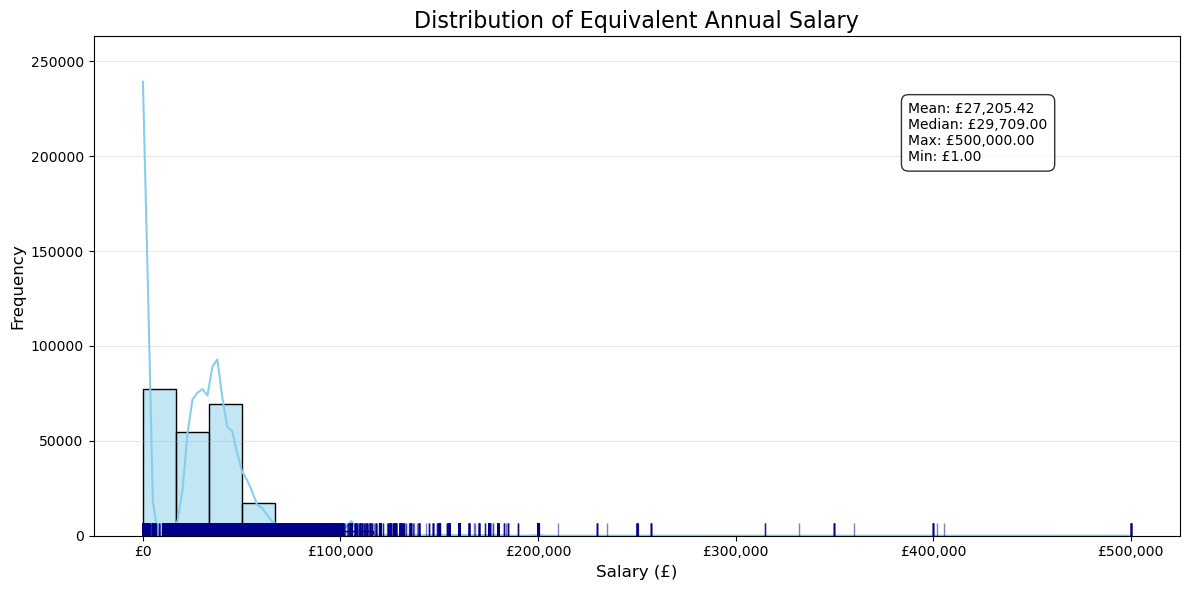

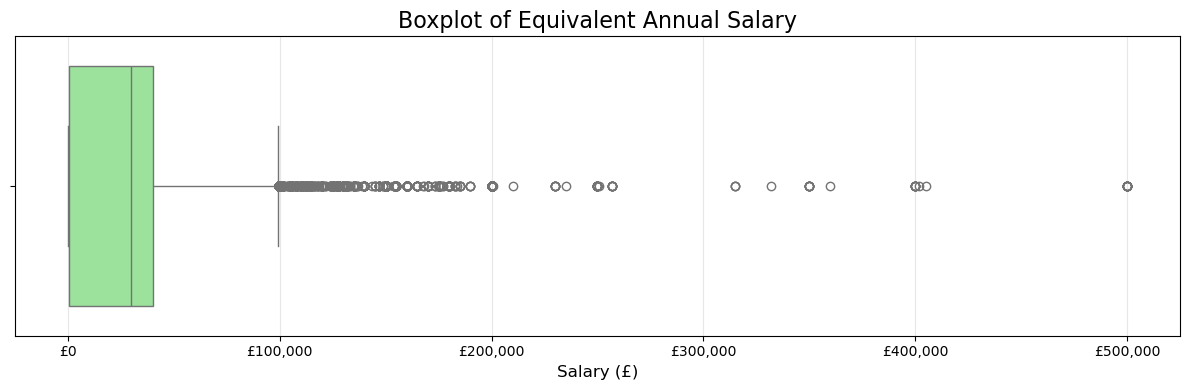

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Remove any remaining NaN values for the visualization
salary_data = combined_df['equivalent_annual_salary'].dropna()

# Create a figure with an appropriate size
plt.figure(figsize=(12, 6))

# Create a histogram with KDE (Kernel Density Estimation) overlay
# This gives you both the histogram bars and a smooth curve
ax = sns.histplot(salary_data, kde=True, color='skyblue', bins=30)

# Add a rug plot at the bottom to show the actual data points
sns.rugplot(salary_data, color='darkblue', alpha=0.5, ax=ax)

# Add some statistics as annotations
mean_salary = salary_data.mean()
median_salary = salary_data.median()
max_salary = salary_data.max()
min_salary = salary_data.min()

stats_text = f"Mean: £{mean_salary:,.2f}\nMedian: £{median_salary:,.2f}\nMax: £{max_salary:,.2f}\nMin: £{min_salary:,.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Set titles and labels
plt.title('Distribution of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Salary (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Format x-axis with commas for thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Add grid lines for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Let's also create a boxplot to better visualize outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=salary_data, orient='h', color='lightgreen')
plt.title('Boxplot of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Salary (£)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2. Apply some logic to make annual equivalent salaries

Current salary statistics:
count    228479.000000
mean      27205.415815
std       24856.404662
min           1.000000
25%         359.000000
50%       29709.000000
75%       40000.000000
max      500000.000000
Name: equivalent_annual_salary, dtype: float64

Updated equivalent annual salaries:
             salary  equivalent_annual_salary
1           £66,181                   66181.0
2               £18                   37440.0
3           £20,000                   20000.0
5          £100,000                  100000.0
6           £36,718                   36718.0
7           £28,000                   28000.0
9           £30,000                   30000.0
10          £39,500                   39500.0
11          £26,273                   26273.0
12  £38228 ANNUALLY                   99320.0


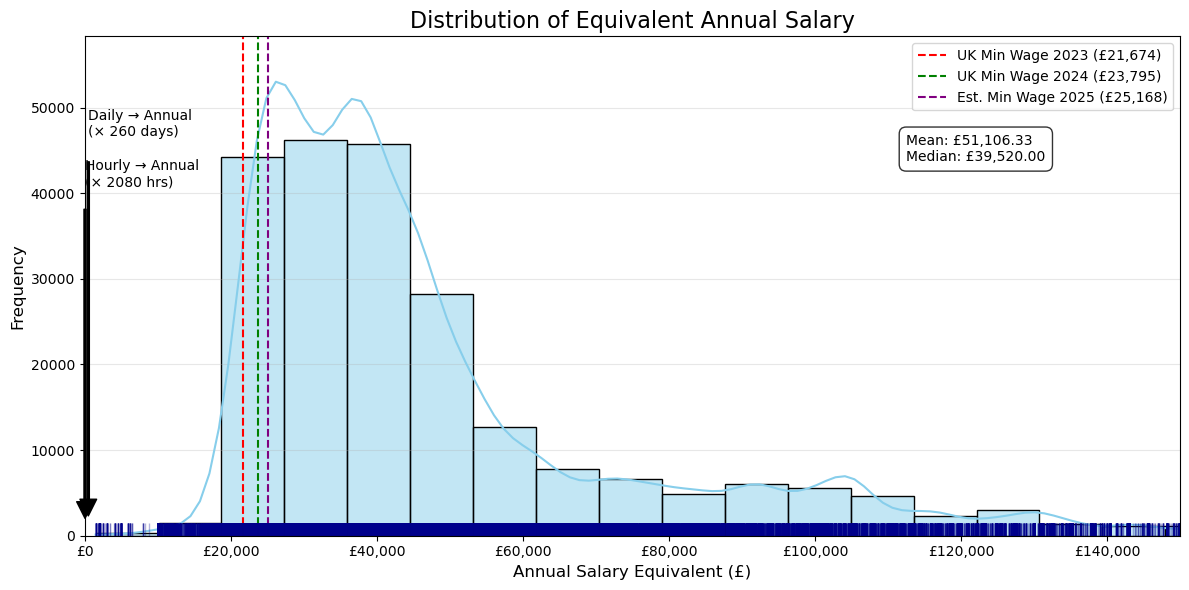

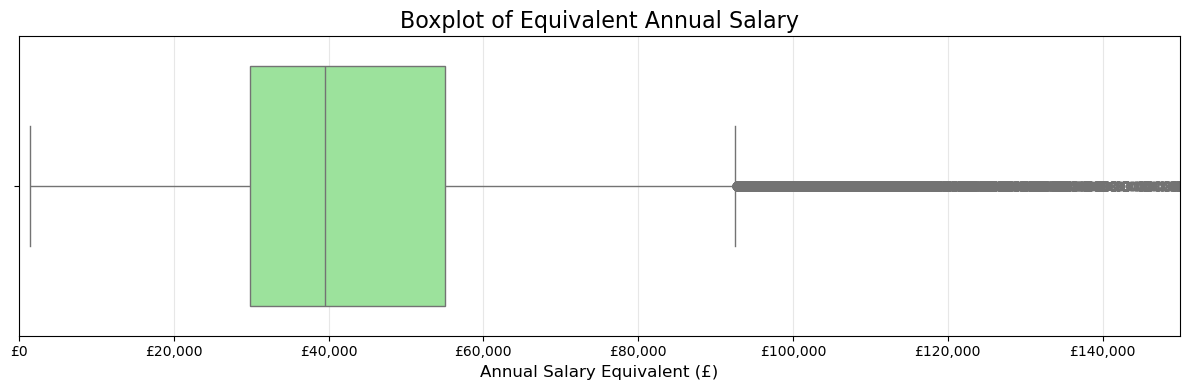

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's get some statistics on our current equivalent_annual_salary
# to help us define reasonable thresholds
stats = combined_df['equivalent_annual_salary'].describe()
print("Current salary statistics:")
print(stats)

# Define the transformation function with appropriate thresholds
def calculate_annual_equivalent(salary_value):
    if pd.isna(salary_value):
        return np.nan
    
    # Clearly hourly rate (below £100)
    if salary_value < 100:
        # Hourly rate: 40 hours × 52 weeks = 2,080 hours per year
        return salary_value * 2080
    
    # Likely daily rate (between £100 and £1,000)
    elif salary_value >= 100 and salary_value <= 1000:
        # Daily rate: 5 days × 52 weeks = 260 working days per year
        return salary_value * 260
    
    # Already an annual salary (above £1,000)
    else:
        # Cap extremely high values that may be errors
        if salary_value > 250000:
            return np.nan
        return salary_value

# Apply the transformation
combined_df['equivalent_annual_salary'] = combined_df['equivalent_annual_salary'].apply(calculate_annual_equivalent)

# Display the updated results
print("\nUpdated equivalent annual salaries:")
print(combined_df[['salary', 'equivalent_annual_salary']].head(10))

# Visualize the distribution
plt.figure(figsize=(12, 6))

# Get the UK National Minimum Wage values (hourly rates × 2080 hours)
# 2023: £10.42 per hour for adults aged 23+
# 2024: £11.44 per hour for adults aged 21+
# 2025: Estimated at £12.10 per hour based on trends
min_wage_2023 = 10.42 * 2080  # = £21,674
min_wage_2024 = 11.44 * 2080  # = £23,795
min_wage_2025 = 12.10 * 2080  # = £25,168

# Create a histogram with KDE overlay
salary_data = combined_df['equivalent_annual_salary'].dropna()
ax = sns.histplot(salary_data, kde=True, color='skyblue', bins=30)

# Add vertical lines for minimum wages
plt.axvline(x=min_wage_2023, color='red', linestyle='--', label='UK Min Wage 2023 (£21,674)')
plt.axvline(x=min_wage_2024, color='green', linestyle='--', label='UK Min Wage 2024 (£23,795)')
plt.axvline(x=min_wage_2025, color='purple', linestyle='--', label='Est. Min Wage 2025 (£25,168)')

# Add a rug plot at the bottom to show the actual data points
sns.rugplot(salary_data, color='darkblue', alpha=0.3, ax=ax)

# Add annotations for the thresholds we used in our transformation
plt.annotate('Hourly → Annual\n(× 2080 hrs)', xy=(50, 0), xytext=(50, ax.get_ylim()[1]*0.7),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
plt.annotate('Daily → Annual\n(× 260 days)', xy=(500, 0), xytext=(500, ax.get_ylim()[1]*0.8),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Calculate statistics for the annotation
mean_salary = salary_data.mean()
median_salary = salary_data.median()
stats_text = f"Mean: £{mean_salary:,.2f}\nMedian: £{median_salary:,.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Add titles and labels
plt.title('Distribution of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Annual Salary Equivalent (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Format x-axis with commas for thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Adjust limits to focus on the meaningful part of the distribution
plt.xlim(0, 150000)

# Add grid lines for better readability
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Let's also create a boxplot to visualize outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=salary_data, orient='h', color='lightgreen')
plt.title('Boxplot of Equivalent Annual Salary', fontsize=16)
plt.xlabel('Annual Salary Equivalent (£)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 150000)
plt.tight_layout()
plt.show()

Remove jobs (or at least their salary as 'missing') for jobs with an ASE of less than the 2023 minimum wage.

Data points lost: 6968 (3.05% of the data)
Before filtering - 25th percentile: £29,840.00
After filtering - 25th percentile: £30,000.00
Before filtering - 50th percentile: £39,520.00
After filtering - 50th percentile: £40,000.00
Before filtering - 75th percentile: £55,000.00
After filtering - 75th percentile: £56,313.00


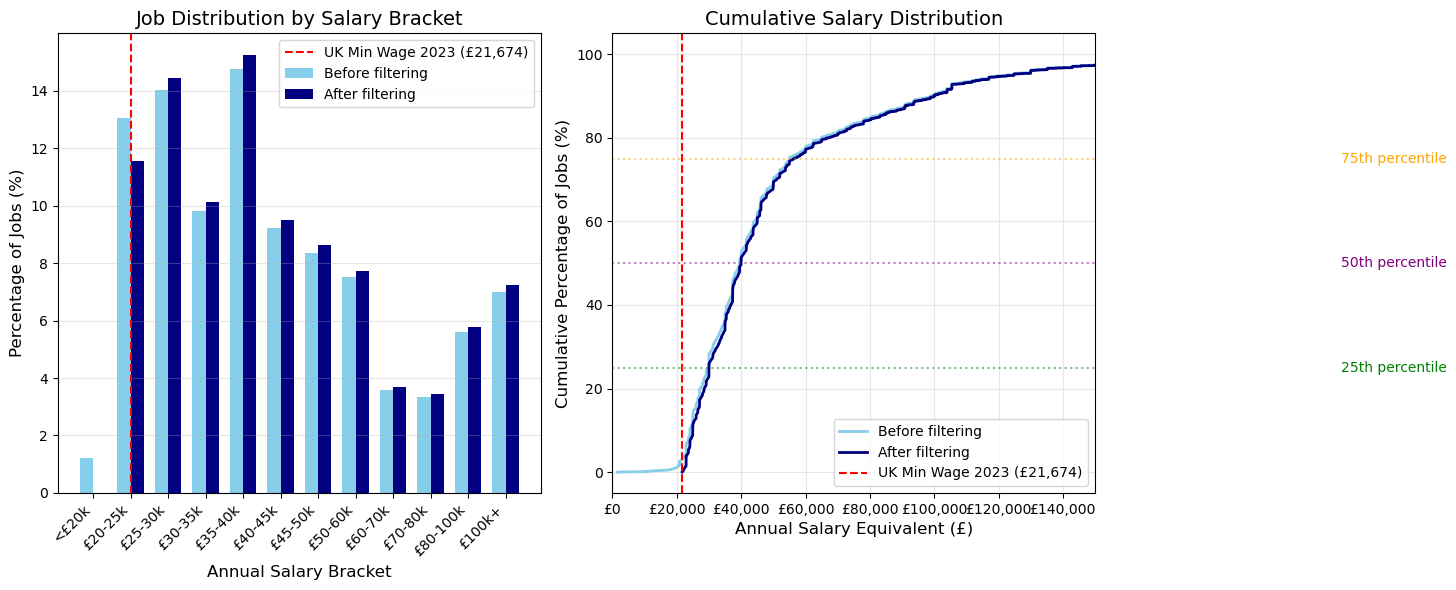


Before filtering - Median: £39,520.00, Mean: £51,106.33
After filtering - Median: £40,000.00, Mean: £52,118.33


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the 2023 UK minimum wage annual equivalent
min_wage_2023 = 10.42 * 2080  # = £21,674

# Get the data
before_filtering = combined_df['equivalent_annual_salary'].dropna()
after_filtering = combined_df['filtered_annual_salary'].dropna()

# Count how many entries we have before and after filtering
total_before = before_filtering.count()
total_after = after_filtering.count()
points_lost = total_before - total_after
percentage_lost = (points_lost / total_before) * 100 if total_before > 0 else 0

print(f"Data points lost: {points_lost} ({percentage_lost:.2f}% of the data)")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Percentage of jobs by salary bracket
# Create salary brackets
brackets = [0, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 80000, 100000, 150000]
bracket_labels = ['<£20k', '£20-25k', '£25-30k', '£30-35k', '£35-40k', '£40-45k', 
                 '£45-50k', '£50-60k', '£60-70k', '£70-80k', '£80-100k', '£100k+']

# Calculate percentage in each bracket for both distributions
before_counts = pd.cut(before_filtering, bins=brackets).value_counts().sort_index()
before_percent = before_counts / total_before * 100

after_counts = pd.cut(after_filtering, bins=brackets).value_counts().sort_index()
after_percent = after_counts / total_after * 100

# Plot the percentage bars
x = np.arange(len(bracket_labels))
width = 0.35
ax1.bar(x - width/2, before_percent, width, label='Before filtering', color='skyblue')
ax1.bar(x + width/2, after_percent, width, label='After filtering', color='navy')

# Add reference line for min wage
min_wage_bracket_index = next((i for i, b in enumerate(brackets) if b > min_wage_2023)) - 1
ax1.axvline(x=min_wage_bracket_index, color='red', linestyle='--', 
           label=f'UK Min Wage 2023 (£{min_wage_2023:,.0f})')

# Customize plot 1
ax1.set_xlabel('Annual Salary Bracket', fontsize=12)
ax1.set_ylabel('Percentage of Jobs (%)', fontsize=12)
ax1.set_title('Job Distribution by Salary Bracket', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(bracket_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Cumulative distribution
# Sort the data
before_sorted = np.sort(before_filtering)
after_sorted = np.sort(after_filtering)

# Calculate cumulative distributions (percentiles)
before_y = np.arange(1, len(before_sorted) + 1) / len(before_sorted) * 100
after_y = np.arange(1, len(after_sorted) + 1) / len(after_sorted) * 100

# Plot cumulative distributions
ax2.plot(before_sorted, before_y, label='Before filtering', color='skyblue', linewidth=2)
ax2.plot(after_sorted, after_y, label='After filtering', color='navy', linewidth=2)

# Add reference line for min wage
ax2.axvline(x=min_wage_2023, color='red', linestyle='--', 
           label=f'UK Min Wage 2023 (£{min_wage_2023:,.0f})')

# Add annotations for key percentiles
percentiles = [25, 50, 75]
colors = ['green', 'purple', 'orange']
for i, p in enumerate(percentiles):
    before_val = np.percentile(before_filtering, p)
    after_val = np.percentile(after_filtering, p)
    
    # Plot horizontal lines at percentiles
    ax2.axhline(y=p, color=colors[i], linestyle=':', alpha=0.5)
    
    # Add annotations
    ax2.text(ax2.get_xlim()[1]*0.95, p, f'{p}th percentile', 
             color=colors[i], va='center', ha='right')
    
    # Print values
    print(f"Before filtering - {p}th percentile: £{before_val:,.2f}")
    print(f"After filtering - {p}th percentile: £{after_val:,.2f}")

# Customize plot 2
ax2.set_xlabel('Annual Salary Equivalent (£)', fontsize=12)
ax2.set_ylabel('Cumulative Percentage of Jobs (%)', fontsize=12)
ax2.set_title('Cumulative Salary Distribution', fontsize=14)
ax2.set_xlim(0, 150000)
ax2.grid(alpha=0.3)
ax2.legend(loc='lower right')

# Format x-axis with commas for thousands
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

plt.tight_layout()
plt.show()

# Print additional statistics
print(f"\nBefore filtering - Median: £{before_filtering.median():,.2f}, Mean: £{before_filtering.mean():,.2f}")
print(f"After filtering - Median: £{after_filtering.median():,.2f}, Mean: £{after_filtering.mean():,.2f}")

# Step 6. Jobs

In [ ]:
## 6.1 